# Download biological occurrences data from EMODnet Biology

> An existence of a particular organism or defined group of organisms considered to be taxonomically homogeneous, at a particular place at a particular time

https://dwc.tdwg.org/terms/#occurrence

The EMODnet Biology occurrences data are available via [Web Feature services (WFS)](https://www.ogc.org/publications/standard/wfs/). The most user-friendly way of querying the EMODnet Biology WFS service is using the emodnet.wfs R package. This package allows interrogation of and access to [EMODnet's, European Marine Observation and Data Network, geographic vector data](https://emodnet.ec.europa.eu/en/emodnet-web-service-documentation#inline-nav-3) in R through the [EMODnet Web Feature Services](https://emodnet.ec.europa.eu/en/data-0). [Web Feature services (WFS)](https://www.ogc.org/publications/standard/wfs/) represent a change in the way geographic information is created, modified and exchanged on the Internet and offer direct fine-grained access to geographic information at the feature and feature property level. 
Features are representation of geographic entities, such as a coastlines, marine protected areas, offshore platforms, or fishing areas. In WFS, features have geometry (spatial information) and attributes (descriptive data).
emodnet.wfs aims at offering an user-friendly interface to this rich data.

We will use the [`emodnet.wfs`](https://emodnet.github.io/emodnet.wfs/) R package to query EMODnet Biology occurrences data. For illustrative purposes, we will use [`dplyr`](https://dplyr.tidyverse.org/), [`stringr`](https://stringr.tidyverse.org/) and [`sf`](https://r-spatial.github.io/sf/) to manipulate dataframes, strings and geospatial vector objects respectively. [`ggplot2`](https://ggplot2.tidyverse.org/) will allow us to plot data. [`rnaturalearth`](https://cran.r-project.org/package=rnaturalearth), [`rnaturalearthdata`](https://cran.r-project.org/package=rnaturalearthdata) and [`mregions2`](https://docs.ropensci.org/mregions2) will provide background geospatial data to create maps.

Remove the comments (#) and run the code below to install

In [ ]:
# install.packages("pak")
# pak::pkg_install("EMODnet/emodnet.wfs")
# install.packages("dplyr")
# install.packages("stringr")
# install.packages("sf")
# install.packages("ggplot2")
# install.packages("rnaturalearth")
# install.packages("rnaturalearthdata")
# install.packages("mregions2")

## Finding the EMODnet Biology occurrences layers

The package `emodnet.wfs` allows to access all WFS services of all EMODnet thematic lots. All different services are summarized with the `emodnet_wfs()` function, returning a data frame with the different services.

In [ ]:
library(emodnet.wfs)
library(dplyr)
library(stringr)
library(sf)
library(ggplot2)
library(mregions2)
library(rnaturalearth)
library(rnaturalearthdata)

# Get the list of available services
emodnet_wfs()


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.12.2, GDAL 3.8.4, PROJ 9.4.0; sf_use_s2() is TRUE


Linked against: 3.12.2-CAPI-1.18.2 compiled against: 3.12.1-CAPI-1.18.1

It is probably a good idea to reinstall sf (and maybe lwgeom too)


Attaching package: ‘rnaturalearthdata’


The following object is masked from ‘package:rnaturalearth’:

    countries110




emodnet_thematic_lot,service_name,service_url
<chr>,<chr>,<chr>
EMODnet Bathymetry,bathymetry,https://ows.emodnet-bathymetry.eu/wfs
EMODnet Biology,biology,https://geo.vliz.be/geoserver/Emodnetbio/wfs
EMODnet Biology,biology_occurrence_data,https://geo.vliz.be/geoserver/Dataportal/wfs
EMODnet Chemistry,chemistry_cdi_data_discovery_and_access_service,https://geo-service.maris.nl/emodnet_chemistry/wfs
EMODnet Chemistry,chemistry_cdi_distribution_observations_per_category_and_region,https://geo-service.maris.nl/emodnet_chemistry_p36/wfs
EMODnet Chemistry,chemistry_contaminants,https://geoserver.hcmr.gr/geoserver/EMODNET_SHARED/wfs
EMODnet Chemistry,chemistry_marine_litter,https://www.ifremer.fr/services/wfs/emodnet_chemistry2
EMODnet Geology,geology_coastal_behavior,https://drive.emodnet-geology.eu/geoserver/tno/wfs
EMODnet Geology,geology_events_and_probabilities,https://drive.emodnet-geology.eu/geoserver/ispra/wfs


Passing a `service_name` to the next functions allows to explore and retrieve data. As the name suggests, the EMODnet Biology occurrence data are available at the service `biology_occurrence_data`. 

Let's connect to this data source and explore what is available

In [2]:
# Connect to the WFS service
wfs_bio <- emodnet_init_wfs_client("biology_occurrence_data")

# Get information about the WFS service
bio_info <- emodnet_get_wfs_info(wfs_bio)

# List the available layers
bio_info |> 
  select(layer_name, title, abstract)


Loading ISO 19139 XML schemas...

Loading ISO 19115 codelists...

✔ WFS client created successfully

ℹ Service: "https://geo.vliz.be/geoserver/Dataportal/wfs"

ℹ Version: "2.0.0"



layer_name,title,abstract
<chr>,<chr>,<chr>
abiotic_observations,Dataportal - Abiotic observations,
biotic_observations,Dataportal - Biotic observations,
abiotic_observations_count2,Dataportal - abiotic_observations_count2,
parameters2,Dataportal - parameters2,
eurobis,EMODNet Eurobis,
eurobis-obisenv_basic,EMODnet EurOBIS Basic Occurrence Data,"The Basic Occurrence Data download provides you data for the following 8 essential terms: datasetid, datecollected, decimallongitude, decimallatitude, coordinateuncertaintyinmeters, scientificname, aphiaid, scientificnameaccepted. For more information, please consult: https://www.emodnet-biology.eu/emodnet-data-format."
eurobis-obisenv_count,EMODnet EurOBIS Count of Occurences,"The Count of Occurences retrieves the total number of records available in EMODnet Biology for a certain query. For more information, please consult: https://www.emodnet-biology.eu/emodnet-biology-api."
eurobis-obisenv_full,EMODnet EurOBIS Full Occurrence Data,"The Full Occurence Data offers all the data from the Basic Occurrences plus additional information which may help interpret the basic data such as information on the institute collecting the data, the methodology, the exact time and location (and uncertainty),... For more information, please consult: https://www.emodnet-biology.eu/emodnet-data-format."
eurobis-obisenv,EMODnet EurOBIS Full Occurrence Data and Parameters,"The Full Occurrence Data and Parameters provides you with all measurement or facts associated to the occurrence or the sample. For more information, please consult: https://www.emodnet-biology.eu/emodnet-data-format."


EMODnet Biology shares infrastructure with EurOBIS - the European node of the Ocean Biolodiversity and Information System (OBIS). The biological occurrences available through EMODnet Biology are those hosted by EurOBIS. 

There are [three data formats](https://emodnet.ec.europa.eu/en/biology#biology-data-and-products-format) available in EMODnet Biology, depending on the amount of information offered, and they are in three different WFS layers: 
1. Basic Occurrences Data at `eurobis-obisenv_basic`
2. Full Occurrences Data at `eurobis-obisenv_full`
3. Full Occurrence Data and Parameters at `eurobis-obisenv`

In [3]:
# Filter the three EMODnet Biology occurrence layers
bio_info |> 
  filter(layer_name %in% c(
    "eurobis-obisenv_basic", 
    "eurobis-obisenv_full", 
    "eurobis-obisenv"
  )) |>
  select(title, abstract)

title,abstract
<chr>,<chr>
EMODnet EurOBIS Basic Occurrence Data,"The Basic Occurrence Data download provides you data for the following 8 essential terms: datasetid, datecollected, decimallongitude, decimallatitude, coordinateuncertaintyinmeters, scientificname, aphiaid, scientificnameaccepted. For more information, please consult: https://www.emodnet-biology.eu/emodnet-data-format."
EMODnet EurOBIS Full Occurrence Data,"The Full Occurence Data offers all the data from the Basic Occurrences plus additional information which may help interpret the basic data such as information on the institute collecting the data, the methodology, the exact time and location (and uncertainty),... For more information, please consult: https://www.emodnet-biology.eu/emodnet-data-format."
EMODnet EurOBIS Full Occurrence Data and Parameters,"The Full Occurrence Data and Parameters provides you with all measurement or facts associated to the occurrence or the sample. For more information, please consult: https://www.emodnet-biology.eu/emodnet-data-format."


Full details about the **three data formats** are available at the [EMODnet documentation website](https://emodnet.ec.europa.eu/en/biology#biology-data-and-products-format)

> **Access here the EMODnet documentation website**
>
> 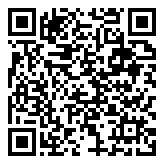
> 
> https://emodnet.ec.europa.eu/en/biology#biology-data-and-products-format





## Query and retrieve EMODnet Biological Ocurrence data in R

Downloading the entire EMODnet Biology occurrences database is not feasible in most cases due to its size — over 30 million occurrences! Instead, querying the data is necessary. The most efficient way to query and access this data in R is by using the [Eurobis download toolbox](https://www.eurobis.org/toolbox/en/download/occurrence/explore) to select your desired dataset and then passing it to emodnet.wfs::emodnet_get_layers(). This web-based tool allows you to construct WFS queries by selecting specific parameters.

> **Access here the EurOBIS toolbox**
>
>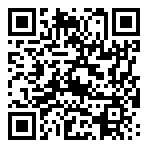
>
> https://www.eurobis.org/toolbox/en/download/occurrence/explore


Once you’ve selected the data you need (e.g., marine mammals in the Mediterranean Sea, commercial fish species in the Pacific Ocean from 1950 to 1960, etc.), you’ll be given the option to **Get webservice URL**. This URL contains the full WFS call, including your query. Simply copy it, and we can pass it to the function in R.

![screenshot](../img/screenshot_download_toolbox.png)

The query is actually contained in the URL in `&viewParams=`. This is a [geoserver specific](https://docs.geoserver.org/main/en/user/data/database/sqlview.html) type of database query. The API also supports OGC and CQL filters, but the layer is not optimized to use these. Using `viewParams` is the most efficient way to query data, and you can always refine your search [by adding an OGC or CQL filter](https://emodnet.github.io/emodnet.wfs/articles/ecql_filtering.html) on top of your query.

Let's see an example

```
https://geo.vliz.be/geoserver/Dataportal/wfs
    ?service=wfs
    &version=1.1.0
    &typeName=eurobis-obisenv
    &request=GetFeature
    &outputFormat=text/csv
    &viewParams=bounds:geoid && ARRAY[1905];taxaselection:mammals
```
We can copy  `&viewParams` and pass it to `emodnet_get_layers()` to get the data in R. However, **it is recommendable to keep the original URL encode**.


In [4]:
# Paste here your URL created with the EurOBIS download toolbox
url <- "https://geo.vliz.be/geoserver/Dataportal/wfs?service=wfs&version=1.1.0&typeName=eurobis-obisenv&request=GetFeature&outputFormat=text%2Fcsv&viewParams=bounds%3Ageoid+%26%26+ARRAY%5B3324%5D%3Btaxaselection%3Amammals"

# Extract the query using a regular expression
query <- str_extract(url, "(?<=viewParams=)[^&]+")

# Pass the query to viewParams argument and query eurobis full data and parameters
df <- emodnet_get_layers(
    wfs_bio,
    layers = "eurobis-obisenv",
    viewParams = query,
    count = 5000, # You can limit the number of rows
    simplify = TRUE
)

# Inspect the data
message(paste0("There are ", nrow(df), " occurrences of marine mammals in the Alboran Sea"))

st_drop_geometry(df) |> head(10)

There are 4262 occurrences of marine mammals in the Alboran Sea



,gml_id,id,modified,datasetid,institutioncode,collectioncode,eventid,datecollected,seasoncollected,yearcollected,⋯,parameter_original_measurement_unit,parameter_conversion_factor_to_standard_unit,event,event_type,event_type_id,occurrenceid_unique,dnaderived,verbatimidentification,higherclassification,taxonid
,<chr>,<dbl>,<dttm>,<chr>,<chr>,<chr>,<chr>,<dttm>,<chr>,<int>,⋯,<chr>,<chr>,<chr>,<chr>,<int>,<int>,<lgl>,<chr>,<chr>,<chr>
1,eurobis-obisenv.fid-2128d3d3_19396501d28_-70bf,1770935,2016-09-20 12:44:24,https://marineinfo.org/id/dataset/1968,Alnilam,429,NA,2006-06-22 02:00:00,summer,2006,⋯,NA,NA,NA,NA,NA,4002467,FALSE,NA,NA,NA
2,eurobis-obisenv.fid-2128d3d3_19396501d28_-70be,1767432,2016-09-20 12:44:24,https://marineinfo.org/id/dataset/1968,Alnilam,429,NA,2003-08-11 02:00:00,summer,2003,⋯,NA,NA,NA,NA,NA,3996016,FALSE,NA,NA,NA
3,eurobis-obisenv.fid-2128d3d3_19396501d28_-70bd,1767434,2016-09-20 12:44:24,https://marineinfo.org/id/dataset/1968,Alnilam,429,NA,2007-09-17 02:00:00,summer,2007,⋯,NA,NA,NA,NA,NA,3996020,FALSE,NA,NA,NA
4,eurobis-obisenv.fid-2128d3d3_19396501d28_-70bc,1767436,2016-09-20 12:44:24,https://marineinfo.org/id/dataset/1968,Alnilam,429,NA,2004-07-18 02:00:00,summer,2004,⋯,NA,NA,NA,NA,NA,3996024,FALSE,NA,NA,NA
5,eurobis-obisenv.fid-2128d3d3_19396501d28_-70bb,1767439,2016-09-20 12:44:24,https://marineinfo.org/id/dataset/1968,Alnilam,429,NA,2003-09-04 02:00:00,summer,2003,⋯,NA,NA,NA,NA,NA,3996028,FALSE,NA,NA,NA
6,eurobis-obisenv.fid-2128d3d3_19396501d28_-70ba,1767442,2016-09-20 12:44:24,https://marineinfo.org/id/dataset/1968,Alnilam,429,NA,2003-07-23 02:00:00,summer,2003,⋯,NA,NA,NA,NA,NA,3996032,FALSE,NA,NA,NA
7,eurobis-obisenv.fid-2128d3d3_19396501d28_-70b9,1767445,2016-09-20 12:44:24,https://marineinfo.org/id/dataset/1968,Alnilam,429,NA,2007-09-25 02:00:00,autumn,2007,⋯,NA,NA,NA,NA,NA,3996037,FALSE,NA,NA,NA
8,eurobis-obisenv.fid-2128d3d3_19396501d28_-70b8,1767448,2016-09-20 12:44:24,https://marineinfo.org/id/dataset/1968,Alnilam,429,NA,2010-08-30 02:00:00,summer,2010,⋯,NA,NA,NA,NA,NA,3996042,FALSE,NA,NA,NA
9,eurobis-obisenv.fid-2128d3d3_19396501d28_-70b7,1767451,2016-09-20 12:44:24,https://marineinfo.org/id/dataset/1968,Alnilam,429,NA,2002-08-24 02:00:00,summer,2002,⋯,NA,NA,NA,NA,NA,3996047,FALSE,NA,NA,NA


We now have the data loaded in R. For instance, we can plot it on a map. We will include the world countries from [Natural Earth](https://www.naturalearthdata.com/) and the Alboran Sea IHO area from [Marine Regions](https://www.marineregions.org/).

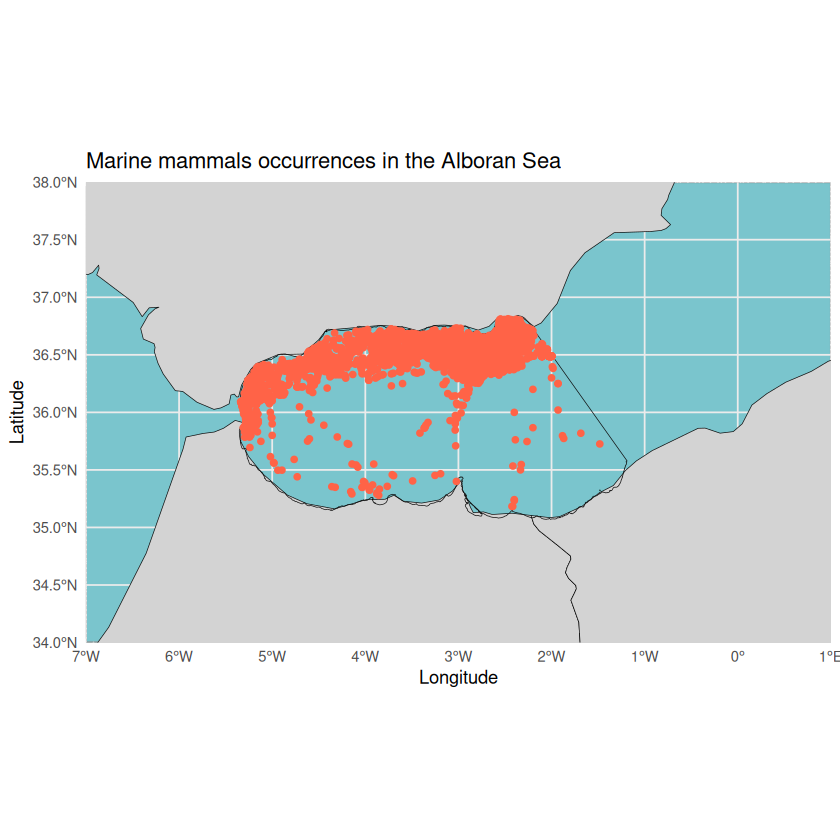

In [5]:
# Get the coastline data
world <- ne_countries(scale = "medium", returnclass = "sf")

# Get the Alboran Sea IHO area
iho <- mrp_get(layer = "iho", cql_filter = "name = 'Alboran Sea'")

# Plot the data with coastline and IHO areas
ggplot(data = df) +
  geom_sf(data = world, fill = "lightgrey", color = "grey5") +
  geom_sf(data = iho, fill = NA, color = "grey5") +
  geom_sf(color = "tomato") +
  coord_sf(xlim = c(-7, 1), ylim = c(34, 38), expand = FALSE) +
  theme_minimal() +
  theme(panel.background = element_rect(fill = "cadetblue3")) +
  labs(title = "Marine mammals occurrences in the Alboran Sea",
       x = "Longitude",
       y = "Latitude")


We can also just save the data for later use. In this case, the data came as an `sf` object, so we can save as e.g. geopackage. But we can also remove the geometry and save as csv, since the geometries are points and their coordinates are in the `decimalLongitude` and `decimalLatitude` columns.

In [6]:
# Create a temporary directory
temp_dir <- tempdir()

# Save as geopackage
gpkg_path <- file.path(temp_dir, "marine_mammals.gpkg")
df |> 
    st_write(gpkg_path, delete_layer = TRUE)

# Save as csv
csv_path <- file.path(temp_dir, "marine_mammals.csv")
df |> 
    st_drop_geometry() |> 
    write.csv(csv_path, row.names = FALSE)

# Print path
message("CSV saved to: ", csv_path)

Writing layer `marine_mammals' to data source 
  `/tmp/RtmpH5DUQC/marine_mammals.gpkg' using driver `GPKG'
Writing 4262 features with 126 fields and geometry type Point.


CSV saved to: /tmp/RtmpH5DUQC/marine_mammals.csv

